In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.datasets import load_diabetes, make_regression
from sklearn.metrics import mean_absolute_percentage_error

**Regressione lineare**

In questa esercitazione utilizzeremo il dataset [Diabetes](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html) messo a disposizione da Scikit Learn.

Il dataset è specificamente pensato per la regressione, ed ha la seguente forma:

| Numero di campioni | Numero di feature | Feature | Target |
| ------------------ | - | - | - |
| $442$ | $10$ | $x \in \mathbb{R}, -0.2 \leq x \leq 0.2$ | $25 \leq y \leq 346$ |

In altre parole, il dataset è composto da $442$ campioni, ciascuno dei quali consta di $10$ feature di tipo numerico, il cui valore è compreso tra $-0.2$ e $0.2$. Per quello che riguarda la variabile predetta, anche questa è di tipo numerico, ed è un intero compreso tra $25$ e $346$.

Iniziamo caricando in memoria il dataset. Ci interessano sia i valori di $(X, y)$, sia i dati sotto forma di dataframe. Partiamo da questi ultimi; per estrarli, imposteremo il parametro `as_frame` a `True`, che li restituisce (per l'appunto) sotto forma di dataframe, sia il parametro `scaled` a `False`, che evita la procedura di normalizzazione.

In [2]:
data = load_diabetes(as_frame=True, scaled=False)
df = data.data
df['progression'] = data.target

Nella creazione del dataframe, abbiamo aggiunto manualmente una colonna chiamata `progression` che contiene la variabile target, indicativa dell'evoluzione della malattia. Proviamo a studiare visivamente l'andamento di questo parametro rispetto all'età dei pazienti, suddividendoli in base al sesso.

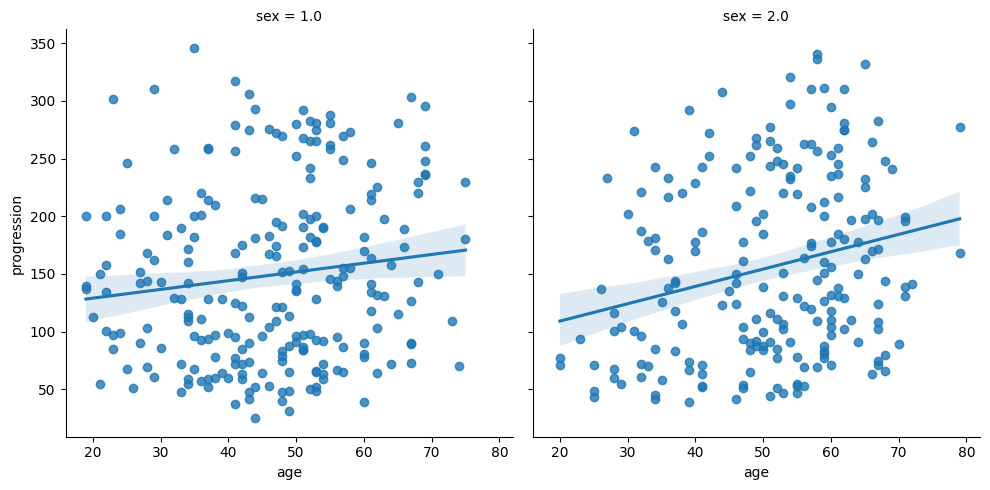

In [3]:
sns.lmplot(data=df, x='age', y='progression', col='sex')
plt.show()

Notiamo che la progressione della malattia è inizialmente più rapida per gli uomini, per poi stabilizzarsi attorno ai 50 anni, oltre i quali sono le donne a progredire più velocemente. Proviamo a mostrare la relazione tra BMI e progressione della malattia.

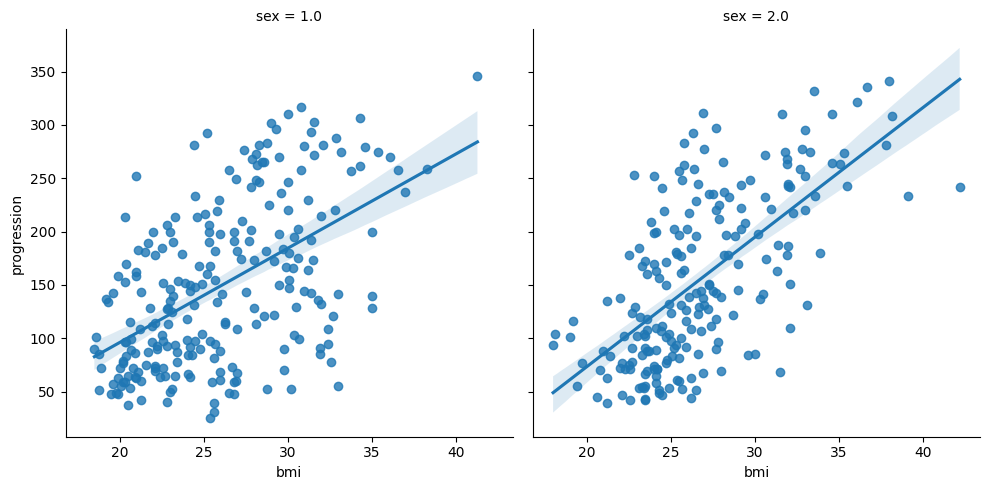

In [4]:
sns.lmplot(data=df, x='bmi', y='progression', col='sex')
plt.show()

Il grafico precedente ci mostra una relazione più chiara tra il parametro BMI e la progressione della malattia. Anche in questo caso, notiamo che per valori più alti di BMI le donne tendono ad avere una progressione più rapida.

Proviamo adesso ad addestrare un regressore lineare, usando tutte le variabili a nostra disposizione. Per farlo, useremo dati *normalizzati* e già organizzati secondo il formato `(X, y)` usando il parametro `return_X_y`.

In [5]:
X, y = load_diabetes(return_X_y=True)
reg = LinearRegression()
reg.fit(X, y)

LinearRegression()

L'addestramento del regressore è completo. Per valutarne le performance possiamo utilizzare il MAPE sfruttando la funzione `mean_absolute_percentage_error`.

In [6]:
y_pred = reg.predict(X)
print(f'MAPE: {round(mean_absolute_percentage_error(y, y_pred), 2)}')

MAPE: 0.39


Come possiamo vedere, l'errore è sufficientemente basso, per cui un modello lineare è in grado di approssimare la relazione tra `X` ed `y`.

Da notare come *non* stiamo plottando alcuna predizione, visto e considerato che lo spazio considerato è a $10$ dimensioni, per cui non può essere visualizzato in due o tre dimensioni.

**Regressione robusta**

Proviamo ad utilizzare il RANSAC per effettaure la regressione.

In [7]:
ransac = RANSACRegressor()
ransac.fit(X, y)
y_pred = ransac.predict(X)
print(f'MAPE: {round(mean_absolute_percentage_error(y, y_pred), 2)}')

MAPE: 0.52


Come possiamo vedere, il MAPE è maggiore. Ciò significa che, per il nostro dataset, è plausibile l'assenza di outlier. Tuttavia, proviamo a vedere cosa accade provando a *riaddestrare* il regressore.

In [8]:
ransac.fit(X, y)
y_pred = ransac.predict(X)
print(f'MAPE: {round(mean_absolute_percentage_error(y, y_pred), 2)}')

MAPE: 0.39


Il valore di MAPE ottenuto è differente! Ciò è legato al fatto che, come già detto, il RANSAC non è deterministico, ma prevede delle elaborazioni su sottoinsiemi casuali di dati.

Per osservare la "vera" potenza del RANSAC, proviamo a generare dei dati molto rumorosi, approssimandoli mediante un regressore lineare ed un RANSAC.

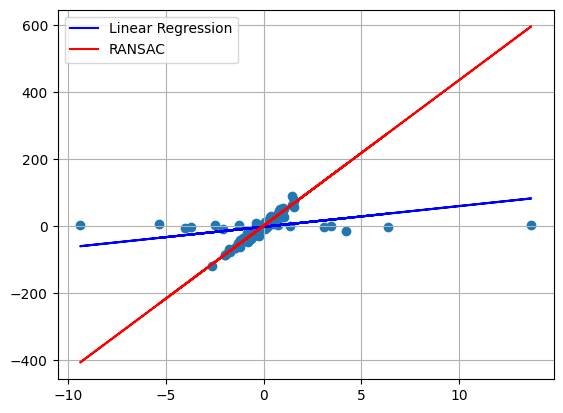

In [9]:
X, y = make_regression(
    n_samples=100,
    n_features=1,
    n_informative=1,
    noise=10,
    random_state=42)

X[-15:] = 5 * np.random.normal(size=(15, 1))
y[-15:] = 5 * np.random.normal(size=15)

reg.fit(X, y)
y_pred_reg = reg.predict(X)

ransac.fit(X, y)
y_pred_ran = ransac.predict(X)

plt.scatter(X, y)
plt.plot(X, y_pred_reg, c='b', label='Linear Regression')
plt.plot(X, y_pred_ran, c='r', label='RANSAC')
plt.grid()
plt.legend()
plt.show()

Come si evince dalla figura, il RANSAC tende a trascurare i dati non appartenenti alla distribuzione "principale", laddove il regressore lineare ne è fortemente influenzato.